# Sine Regression in Macro and Micro Scope

In this notebook I will load previously preparerd data of top performers and create an algorithm to select entry and exit points based on fitted sine waves in the macro and micro scope. 

This algorithm should: 

1) Given a column of stock price data, fit a sine wave and extract features  
2) Compute the derivative of the identified sine wave, identifying zeros as entry and exit points  
3) Fit a sine wave on the diffed price history most recently  
4) Compute the derivative of the micro sine wave and identify entry and exit points for the stock currently   
5) Select stocks that are in both an upward trending portion of their macro wave, and have reached a minimum of their micro wave.   
6) Generate buy and sell signals on the accumulation of these singals.  

Since the data has been saved iteratively to separate files, this workbook should create and functionalize a workflow capable of performing the desired work. The functions should then be saved to an exterior py file, imported, and then looped through iteratively. The results should be extracted and introduced to another dataframe for consideration. 

#### 1) Load the data

Load one example dataset for analysis. Functionalize any loading algorithm and ensure that it can be accessed easily for iterative loading. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [3]:
from sine_modules import load_set

In [4]:
key_name = 'top100alpha.csv'
data_dir = './data/screens/1yeartopperformers/'

tail = '190820.pickle'
#tail = stock + suffix

key_df = pd.read_csv(data_dir+key_name)
key_df.head()

,SYMBOL,mean,std,alpha
0,DOCU,0.669910,3.329333,0.201214
1,APG,0.542511,2.696561,0.201186
2,PRTS,1.168491,6.005884,0.194558
3,TSLA,0.973406,5.113792,0.190349
4,DKNG,0.951621,5.210704,0.182628


In [5]:
stock = key_df['SYMBOL'].loc[0]
stock

'DOCU'

In [8]:
df = load_set(stock, data_dir, tail)

In [11]:
df.head()

,open,high,low,close,volume,date,SYMBOL,prev_close,diff_1,pct_change,log_return
252,213.490,213.53,207.6881,209.47,2763874,2020-08-18,DOCU,207.70,1.77,0.008522,0.008486
251,202.240,209.83,201.9800,207.70,2590486,2020-08-17,DOCU,199.71,7.99,0.040008,0.039228
250,201.355,204.46,197.2100,199.71,1952648,2020-08-14,DOCU,199.38,0.33,0.001655,0.001654
249,194.220,203.85,193.6200,199.38,4048023,2020-08-13,DOCU,193.30,6.08,0.031454,0.030969
248,192.650,196.88,189.1200,193.30,4591084,2020-08-12,DOCU,191.82,1.48,0.007716,0.007686


#### 2) Fit sine to the macro data and visualize 

In [9]:
from sine_modules import fit_sin, plot_sin

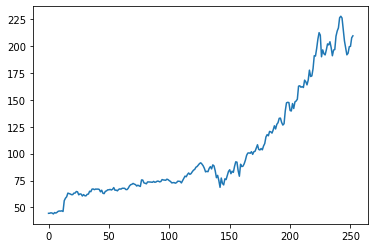

In [10]:
plt.plot(df['close'])

This data does not look promising because of the upward tail recently, which seems ready to throw the hypothesis out upon visualization. However, if we try to make our data stationary by subtracting the simple moving average (30), what happens? 

In [29]:
df['close-sma5'] = df['close'] - df['close'][::-1].rolling(5).mean()[::-1]

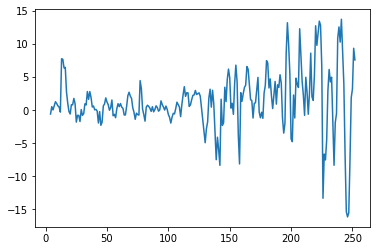

In [30]:
plt.plot(df['close-sma5'])

What if we further divide this number by the volume? 

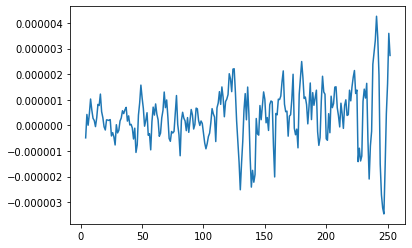

In [31]:
plt.plot(df['close-sma5'] / df['volume'])

In [32]:
df['close-sma5-divvolume'] = df['close-sma5'] / df['volume']

The plot is now far more stationary, although it isnt perfect. 

Can we fit a sine curve to it? I wonder...

In [35]:
y = df['close-sma5-divvolume'].dropna().values
x = df['close-sma5-divvolume'].dropna().index

In [39]:
#y, x

Amplitude=4.756929088381567e-07, Angular freq.=0.43261147992251425, phase=-0.9780718392344105, offset=3.647244871502002e-07, Max. Cov.=0.16269480868047081


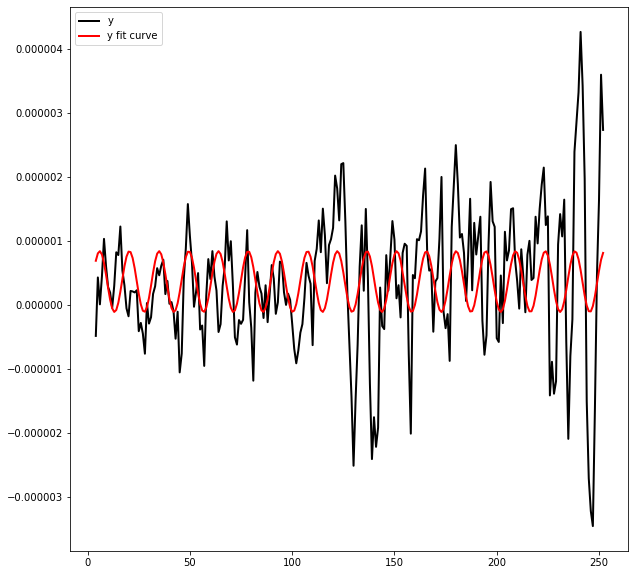

In [38]:
sin_res = fit_sin(x, y)
plt.figure(figsize=(100,20))
plot_sin(x,y,sin_res)

To an eyeball observer, that looks pretty neat. 

A couple problems with it: 

1) Fit to known data only  
2) Not a perfect fit  
3) No approximation of height of curve  

#### 3) Predict the macro trend by computing the derivative of the wave and identifying the next zero point

#### 4) Fit sine to micro diffed data and visualize

In [40]:
df.head()

,open,high,low,close,volume,date,SYMBOL,prev_close,diff_1,pct_change,log_return,close-sma30,close-sma5,close-sma5-divvolume
252,213.490,213.53,207.6881,209.47,2763874,2020-08-18,DOCU,207.70,1.77,0.008522,0.008486,7.558,7.558,2.734567e-06
251,202.240,209.83,201.9800,207.70,2590486,2020-08-17,DOCU,199.71,7.99,0.040008,0.039228,9.318,9.318,3.597008e-06
250,201.355,204.46,197.2100,199.71,1952648,2020-08-14,DOCU,199.38,0.33,0.001655,0.001654,3.192,3.192,1.634703e-06
249,194.220,203.85,193.6200,199.38,4048023,2020-08-13,DOCU,193.30,6.08,0.031454,0.030969,1.852,1.852,4.575073e-07
248,192.650,196.88,189.1200,193.30,4591084,2020-08-12,DOCU,191.82,1.48,0.007716,0.007686,-7.488,-7.488,-1.630987e-06


In [41]:
df['pct_change'] = df['pct_change'] * 100
df['pct_change_by_volume'] = df['pct_change'] / df['volume']

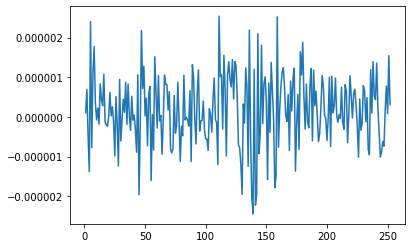

In [42]:
plt.plot(df['pct_change_by_volume'])

In [43]:
y = df['pct_change_by_volume'].dropna().values
x = df['pct_change_by_volume'].dropna().index

Amplitude=-2.476938187896357e-07, Angular freq.=0.7267329775814836, phase=-0.03825670042748135, offset=1.7727036994038507e-07, Max. Cov.=0.39638003373895214


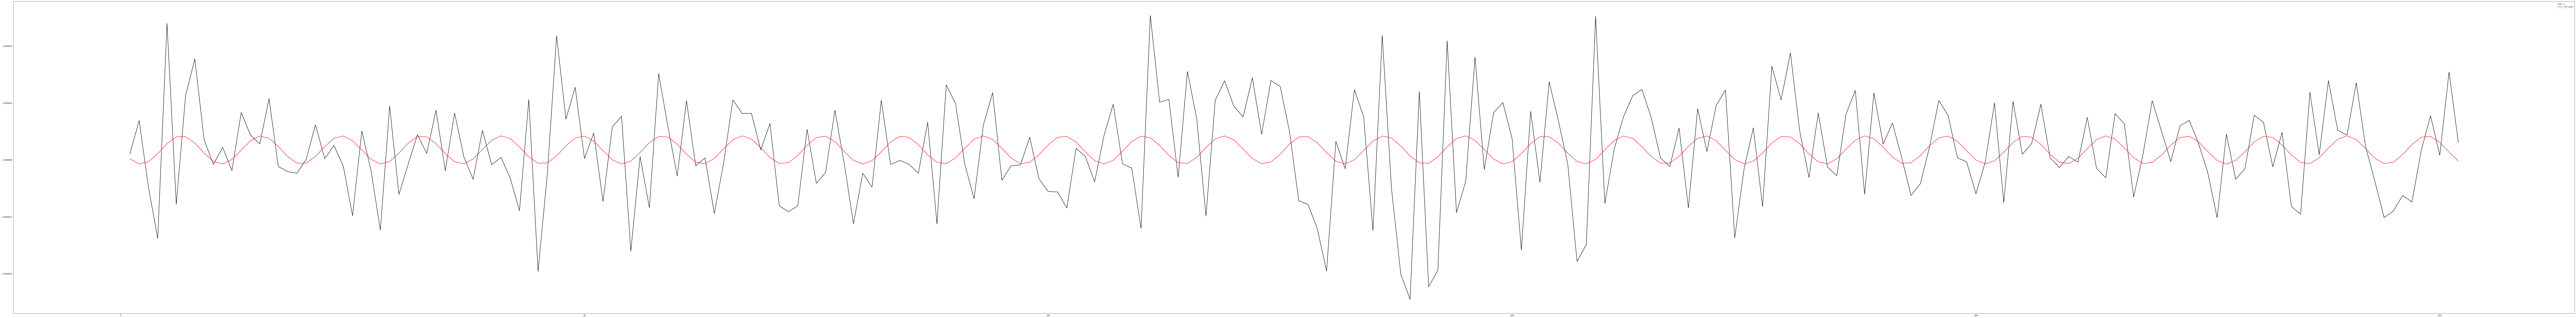

In [45]:
sin_res = fit_sin(x, y)
plt.figure(figsize=(240,30))
plot_sin(x,y,sin_res)

#### 5) Compute the derivative of micro wave, find the next zeros for entry and exit points

#### 6) Save the datasets with the predicted statistics 

Given the analysis, save for production in another workbook